In [2]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# Preprocessing Data

In [2]:
data_root = '../data/'
seed = 27

df = TabularDataset(data_root + 'train_dataset.csv')
df = df.reset_index(drop=True)
# psuedo = TabularDataset(data_root + 'public_dataset_without_gt_latlon.csv')
# psuedo = pd.read_csv(data_root + 'public_dataset_without_gt_latlon.csv')
# psuedo_y = TabularDataset('top1.csv')
# psuedo = pd.concat([psuedo, psuedo_y], axis = 1)
df

,ID,pms_i_ymd,Area,Province,Shop Name,gender,date_of_birth_week,date_of_birth,marital_status,number_of_children,...,Mortgage_balance,Credit Card_balance,Automobile installment purchase_balance,Other installment purchase_balance,Loan for agriculture_balance,Other Loans_balance,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,default_12month
0,202412000001,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1971/5/18,1,2,...,0.0,0.0,0.0,0.0,30000.0,0.0,12,6,0,0
1,202412000002,2018/4/2,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,4,1983/1/5,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
2,202412000003,2018/4/3,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,5,1992/11/19,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,0,0
3,202412000004,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,7,1990/11/3,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
4,202412000005,2018/4/4,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,6,1994/12/16,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32519,202412049586,2018/8/31,webpak,webpak,webpak,F2,3,1995/10/24,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0
32520,202412049587,2018/8/31,webpak,webpak,webpak,F2,3,1979/3/30,1,0,...,0.0,0.0,267504.0,0.0,0.0,0.0,0,0,0,0
32521,202412049588,2018/8/31,webpak,webpak,webpak,M,2,1992/5/11,1,0,...,0.0,0.0,0.0,65780.0,0.0,0.0,0,1,0,0
32522,202412049589,2018/8/31,webpak,webpak,webpak,M,2,1989/6/12,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,1,0


In [3]:
# print(df.iloc[:2].to_json(orient='records'))

## Train data

### Eda

In [4]:
# check data type and missing values
df.info()
# df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32524 entries, 0 to 32523
Data columns (total 61 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       32524 non-null  int64  
 1   pms_i_ymd                                32524 non-null  object 
 2   Area                                     32524 non-null  object 
 3   Province                                 32524 non-null  object 
 4   Shop Name                                32524 non-null  object 
 5   gender                                   32524 non-null  object 
 6   date_of_birth_week                       32524 non-null  int64  
 7   date_of_birth                            32524 non-null  object 
 8   marital_status                           32524 non-null  int64  
 9   number_of_children                       32524 non-null  int64  
 10  postal_code                              32524

In [5]:
df.isna().sum()

ID                                    0
pms_i_ymd                             0
Area                                  0
Province                              0
Shop Name                             0
                                  ...  
Other Loans_balance               12945
Bank inquiry_count                    0
Consumer finance inquiry_count        0
Leasing enquiry_count                 0
default_12month                       0
Length: 61, dtype: int64

In [6]:
def print_high_null_columns(df, threshold=0.01):
    """
    Print columns that have null values exceeding the specified threshold
    
    Parameters:
    df (pandas.DataFrame): Input dataframe to analyze
    threshold (float): Threshold for null percentage (default 0.3 or 30%)
    
    Returns:
    list: List of column names exceeding the null threshold
    """
    # Calculate percentage of null values for each column
    null_percentages = df.isnull().sum() / len(df)
    
    # Filter columns where null percentage exceeds threshold
    high_null_cols = null_percentages[null_percentages > threshold]
    
    # Print results
    print("\nColumns with more than {:.1%} null values:".format(threshold))
    print("-" * 50)
    for col, pct in high_null_cols.items():
        print(f"{col:<30} {pct:.2%} null values")
    
    # Return list of column names for potential dropping
    return list(high_null_cols.index)

print_high_null_columns(df)


Columns with more than 1.0% null values:
--------------------------------------------------
r_propose                      1.50% null values
r_additional_income            10.12% null values
r_spouse_income                8.51% null values
r_generalcode1                 59.33% null values
r_generalcode2                 59.73% null values
r_generalcode3                 3.21% null values
r_generalcode4                 4.37% null values
r_generalcode5                 3.47% null values
Overdraft_count                39.80% null values
Personal Loan_count            39.80% null values
Mortgage_count                 39.80% null values
Credit Card_count              39.80% null values
Automobile installment purchase_count 39.80% null values
Other installment purchase_count 39.80% null values
Loan for agriculture_count     39.80% null values
Other Loans_count              39.80% null values
Overdraft_balance              39.80% null values
Personal Loan_balance          39.80% null values
Mor

['r_propose',
 'r_additional_income',
 'r_spouse_income',
 'r_generalcode1',
 'r_generalcode2',
 'r_generalcode3',
 'r_generalcode4',
 'r_generalcode5',
 'Overdraft_count',
 'Personal Loan_count',
 'Mortgage_count',
 'Credit Card_count',
 'Automobile installment purchase_count',
 'Other installment purchase_count',
 'Loan for agriculture_count',
 'Other Loans_count',
 'Overdraft_balance',
 'Personal Loan_balance',
 'Mortgage_balance',
 'Credit Card_balance',
 'Automobile installment purchase_balance',
 'Other installment purchase_balance',
 'Loan for agriculture_balance',
 'Other Loans_balance']

### Process

In [ ]:
def safe_division(numerator, denominator, default=0):
    """Safe division handling division by zero"""
    return np.where(denominator != 0, numerator / denominator, default)


def drop_columns(df):
    """Drop unnecessary columns"""
    drop_columns = [
        "r_generalcode1",
        "r_generalcode2",
        "r_generalcode4",
        "r_generalcode5",
        "Overdraft_count",
        "Personal Loan_count",
        "Mortgage_count",
        "Credit Card_count",
        "Automobile installment purchase_count",
        "Other installment purchase_count",
        "Loan for agriculture_count",
        "Other Loans_count",
        "Overdraft_balance",
        "Personal Loan_balance",
        "Mortgage_balance",
        "Credit Card_balance",
        "Automobile installment purchase_balance",
        "Other installment purchase_balance",
        "Loan for agriculture_balance",
        "Other Loans_balance",
    ]

    return df.drop(columns=drop_columns)


def handle_missing_values(df):
    """Handle missing values with appropriate strategies"""
    df = df.copy()

    # Simple zero imputation for income
    df["r_additional_income"] = df["r_additional_income"].fillna(0)
    df["r_spouse_income"] = df["r_spouse_income"].fillna(0)

    # Business type specific imputation for credit limit
    df["r_expected_credit_limit"] = df.groupby("c_business_type")[
        "r_expected_credit_limit"
    ].transform(lambda x: x.fillna(x.median()))

    # Mode imputation for categorical
    df["r_generalcode3"] = df["r_generalcode3"].fillna(4)
    df["r_propose"] = df["r_propose"].fillna(
        6
    )  # less than 1.5% missing fill other category
    df["c_date_of_salary_payment"] = df["c_date_of_salary_payment"].fillna(
        1
    )  # less than 1% missing

    return df


def calculate_age(df):
    """Calculate age from date of birth"""
    df = df.copy()
    df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])
    reference_date = pd.to_datetime("2024-01-01")
    df["age"] = (reference_date - df["date_of_birth"]).dt.days // 365

    df["pms_i_ymd"] = pd.to_datetime(df["pms_i_ymd"])
    # Create age at application
    df["age_application"] = (df["pms_i_ymd"] - df["date_of_birth"]).dt.days // 365

    return df.drop(["date_of_birth", "pms_i_ymd"], axis=1)


def calculate_income_features(df):
    """Calculate income-related features"""
    df = df.copy()

    # Basic income calculations
    df["total_income"] = (
        df["c_monthly_salary"] + df["r_additional_income"] + df["r_spouse_income"]
    )

    # Income ratios
    df["income_per_dependent"] = safe_division(
        df["total_income"], (df["number_of_children"] + 1)
    )
    df["income_per_resident"] = safe_division(
        df["total_income"], df["number_of_resident"]
    )
    df["multiple_income_sources"] = (
        (df["r_additional_income"] > 0) | (df["r_spouse_income"] > 0)
    ).astype(int)

    # Drop original columns
    df = df.drop(columns=["c_monthly_salary", "r_additional_income", "r_spouse_income"])

    return df


def calculate_stability_features(df):
    """Calculate stability-related features"""
    df = df.copy()

    # Employment stability
    df["employment_months"] = (
        df["c_number_of_working_year"] * 12 + df["c_number_of_working_month"]
    )
    df["job_stability_score"] = safe_division(
        df["employment_months"], df["age"], default=0
    ).clip(max=1, min=0)

    # Living stability with minimum thresholds
    df["living_months"] = df["living_period_year"] * 12 + df["living_period_month"]
    df["residence_stability_score"] = safe_division(
        df["living_months"], df["age"], default=0
    ).clip(max=1, min=0)

    # Drop original columns
    df = df.drop(
        columns=[
            "c_number_of_working_year",
            "c_number_of_working_month",
            "living_period_year",
            "living_period_month",
        ]
    )

    return df


def calculate_risk_features(df):
    """Calculate risk-related features"""
    df = df.copy()

    # Credit inquiries
    df["total_inquiries"] = (
        df["Bank inquiry_count"] + df["Consumer finance inquiry_count"]
    )
    df["high_inquiry_flag"] = (df["total_inquiries"] > 3).astype(int)

    # Debt metrics
    df["debt_burden"] = safe_division(
        df["r_allloan_amount"], (df["total_income"] * 12)
    ).clip(min=0, max=10)
    df["credit_limit_ratio"] = safe_division(
        df["r_expected_credit_limit"], df["total_income"]
    ).clip(min=0, max=10)

    # Business risk
    business_risk_map = {
        16: 1,
        14: 1,  # Low risk (government, education)
        15: 2,
        11: 2,
        12: 2,  # Medium-low risk (hospital, finance, insurance)
        4: 3,
        7: 3,  # Medium risk (manufacturing, business service)
        8: 4,
        5: 4,  # High risk (individual service, merchant)
    }
    df["business_risk_level"] = df["c_business_type"].map(business_risk_map).fillna(3)

    # Composite risk score
    df["high_risk_flags"] = (
        (df["living_months"] < 12).astype(int)
        + (df["employment_months"] < 12).astype(int)
        + (df["debt_burden"] > 0.5).astype(int)
        + (df["high_inquiry_flag"])
    )

    return df


def encode_categorical_features(df):
    """Encode categorical features"""
    categorical_cols = ["gender", "Area", "Province", "Shop Name", "apply"]
    return pd.get_dummies(df, columns=categorical_cols)


def preprocess(df):
    """Main preprocessing pipeline"""
    df = df.copy()

    # Basic preprocessing
    df = drop_columns(df)
    df = handle_missing_values(df)

    # Feature engineering
    df = calculate_age(df)
    df = calculate_income_features(df)
    df = calculate_stability_features(df)
    df = calculate_risk_features(df)

    # Encoding and scaling
    # df = encode_categorical_features(df)

    df = df.replace([np.inf, -np.inf], np.nan)
    return df


In [87]:
data = preprocess(df)

# data = data.dropna()
data["y"] = data["default_12month"].astype("int")

data = data.drop(columns=["default_12month"])
data = data.reset_index(drop=True)

# pd.set_option('display.max_columns', None)
data.isna().sum()

ID                                0
Area                              0
Province                          0
Shop Name                         0
gender                            0
date_of_birth_week                0
marital_status                    0
number_of_children                0
postal_code                       0
tel_category                      0
number_of_resident                0
type_of_residence                 0
c_postal_code                     1
c_business_type                   0
c_number_of_employee              0
c_position                        0
c_occupation                      0
c_employment_status               0
c_salary_payment_methods          0
c_date_of_salary_payment          0
media                             0
place_for_sending_information     0
r_expected_credit_limit           0
r_propose                         0
r_allloan_case                    0
r_allloan_amount                  0
r_generalcode3                    0
apply                       

In [ ]:
test_size = int(0.1 * len(data))

test_data = data.sample(test_size, random_state=seed)
train_data = data.drop(test_data.index)
train_data = train_data.reset_index(drop=True)
train_data

ID                                0
Area                              0
Province                          0
Shop Name                         0
gender                            0
date_of_birth_week                0
marital_status                    0
number_of_children                0
postal_code                       0
tel_category                      0
number_of_resident                0
type_of_residence                 0
c_postal_code                     0
c_business_type                   0
c_number_of_employee              0
c_position                        0
c_occupation                      0
c_employment_status               0
c_salary_payment_methods          0
c_date_of_salary_payment          0
media                             0
place_for_sending_information     0
r_expected_credit_limit           0
r_propose                         0
r_allloan_case                    0
r_allloan_amount                  0
r_generalcode3                    0
apply                       

In [38]:
data['y'].value_counts(normalize=True)

y
0    0.870487
1    0.129513
Name: proportion, dtype: float64

In [81]:
test = TabularDataset(data_root + "public_dataset_without_gt.csv")
test = preprocess(test)
# fill with mean if number else mode
# for column in test.columns:
#     if test[column].dtype in [np.float64, np.int64]:
#         test[column].fillna(test[column].mean(), inplace=True)
#     else:
#         test[column].fillna(test[column].mode()[0], inplace=True)
test

,ID,Area,Province,Shop Name,gender,date_of_birth_week,marital_status,number_of_children,postal_code,tel_category,number_of_resident,type_of_residence,c_postal_code,c_business_type,c_number_of_employee,c_position,c_occupation,c_employment_status,c_salary_payment_methods,c_date_of_salary_payment,media,place_for_sending_information,r_expected_credit_limit,r_propose,r_allloan_case,r_allloan_amount,r_generalcode3,apply,Bank inquiry_count,Consumer finance inquiry_count,Leasing enquiry_count,age,age_application,total_income,income_per_dependent,income_per_resident,multiple_income_sources,employment_months,job_stability_score,living_months,residence_stability_score,total_inquiries,high_inquiry_flag,debt_burden,credit_limit_ratio,business_risk_level,high_risk_flags
0,202412000196,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,2,10120,3,4,6,10500.0,7,20,5,55,5,1,31.0,3,2,5000.0,5.0,0.0,0,1.0,WI,1,3,0,42,37,24150.0,8050.00,6037.5,1,1,0.023810,108,2.571429,4,1,0.000000,0.207039,3.0,2
1,202412000241,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,2,2,0,10120,3,5,6,10120.0,4,60,5,54,1,1,1.0,7,1,10000.0,5.0,3.0,20000,2.0,WI,0,12,0,30,25,24700.0,24700.00,4940.0,1,23,0.766667,38,1.266667,12,1,0.067476,0.404858,3.0,1
2,202412000242,Bangkok Metropolitan Region,Bangkok,Silom Complex,F2,4,1,0,10120,3,1,6,10120.0,4,300,5,54,2,1,25.0,7,1,20000.0,5.0,2.0,17000,2.0,WI,1,4,0,47,42,8800.0,8800.00,8800.0,1,3,0.063830,24,0.510638,5,1,0.160985,2.272727,3.0,2
3,202412000243,Bangkok Metropolitan Region,Bangkok,Silom Complex,F1,5,3,3,10530,3,6,3,10500.0,5,5000,2,20,1,1,31.0,7,2,50000.0,5.0,3.0,50000,2.0,WI,12,2,1,44,38,25215.0,6303.75,4202.5,0,76,1.727273,120,2.727273,14,1,0.165246,1.982947,4.0,1
4,202412000244,Bangkok Metropolitan Region,Bangkok,Silom Complex,M,2,2,2,10700,3,5,6,10120.0,5,3400,4,51,1,1,30.0,3,1,10000.0,5.0,0.0,0,1.0,WI,0,0,0,35,29,36660.0,12220.00,7332.0,1,16,0.457143,16,0.457143,0,0,0.000000,0.272777,4.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6562,202412049778,webpak,webpak,webpak,F2,7,2,1,20230,3,2,6,20230.0,4,28,5,54,1,1,25.0,1,1,54000.0,6.0,0.0,0,4.0,OT,0,3,0,38,33,10900.0,5450.00,5450.0,0,12,0.315789,27,0.710526,3,0,0.000000,4.954128,3.0,0
6563,202412049779,webpak,webpak,webpak,F2,1,1,0,20230,3,1,6,21140.0,4,3000,5,54,1,1,25.0,1,2,0.0,6.0,0.0,0,4.0,OT,0,7,0,30,24,10300.0,10300.00,10300.0,0,21,0.700000,26,0.866667,7,1,0.000000,0.000000,3.0,1
6564,202412049780,webpak,webpak,webpak,M,5,2,0,21140,3,4,2,20230.0,7,1000,5,55,5,1,3.0,1,1,34000.0,6.0,0.0,0,4.0,OT,0,0,0,54,49,6930.0,6930.00,1732.5,0,24,0.444444,62,1.148148,0,0,0.000000,4.906205,3.0,0
6565,202412049781,webpak,webpak,webpak,F2,3,1,0,20000,3,1,6,20000.0,4,1000,5,54,1,1,27.0,1,2,14000.0,5.0,0.0,0,4.0,OT,2,3,0,36,30,14228.0,14228.00,14228.0,0,60,1.666667,67,1.861111,5,1,0.000000,0.983975,3.0,1


In [83]:
test.isna().sum()

ID                                0
Area                              0
Province                          0
Shop Name                         0
gender                            0
date_of_birth_week                0
marital_status                    0
number_of_children                0
postal_code                       0
tel_category                      0
number_of_resident                0
type_of_residence                 0
c_postal_code                     1
c_business_type                   0
c_number_of_employee              0
c_position                        0
c_occupation                      0
c_employment_status               0
c_salary_payment_methods          0
c_date_of_salary_payment          0
media                             0
place_for_sending_information     0
r_expected_credit_limit           0
r_propose                         0
r_allloan_case                    0
r_allloan_amount                  0
r_generalcode3                    0
apply                       

# Train

In [14]:
preset = [
    "best_quality",
    "high_quality",
    "good_quality",
    "medium_quality",
    "optimize_for_deployment",
][1]

included = ["XGB", "GMB", "RF", "XT", "catboost"]
# excluded_model_types = ["KNN", "NN_TORCH", "catboost"]
# problem_type = "regression"
problem_type = "binary"


eval_metric = ["roc_auc", "f1", "average_precision"]

time_limit = 30 * 60
num_cpus = 8
num_gpus = 1
predictor = TabularPredictor(
    label="y",
    verbosity=2,
    problem_type=problem_type,
    eval_metric=eval_metric[0],
    sample_weight="balance_weight",  # "auto_weight"
).fit(
    train_data=train_data,
    presets=preset,
    num_gpus=num_gpus,
    num_cpus=num_cpus,
    time_limit=time_limit,
    included_model_types=included,
    #  excluded_model_types = excluded_model_types,
    num_bag_folds=4,
)

No path specified. Models will be saved in: "AutogluonModels/ag-20241207_085612"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.12.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Tue Nov 5 00:21:55 UTC 2024
CPU Count:          12
Memory Avail:       19.11 GB / 23.47 GB (81.4%)
Disk Space Avail:   895.38 GB / 1006.85 GB (88.9%)
Presets specified: ['high_quality']
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
Note: `save_bag_folds=False`! This will greatly reduce peak disk usage during fit (by ~8x), but runs the risk of an out-of-memory error during model refit if memory is small relative to the data size.
	You can avoid this risk by setting `save_bag_folds=True`.
DyStack is enabled (dynamic_sta

# load model

In [23]:
model_path = "/root/projects/Aihack/code/AutogluonModels/ag-20241207_085612"
predictor = TabularPredictor.load(model_path)

# Prediction and Evaluation

In [24]:
# test on train data
top = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                             model  score_val eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              WeightedEnsemble_L3   0.637599     roc_auc      15.291547  652.741905                0.002162           1.034717            3      False         53
1              WeightedEnsemble_L2   0.632736     roc_auc       3.980775  210.632495                0.001972           1.024061            2      False         29
2             ExtraTrees_r4_BAG_L1   0.626659     roc_auc       0.398012    1.757500                0.398012           1.757500            1       True         17
3          RandomForest_r34_BAG_L2   0.625226     roc_auc      14.288309  576.429198                0.423692          12.621767            2      False         45
4          RandomForest_r34_BAG_L1   0.625095     roc_auc       0.377067    5.082125                0.377067           5.08

In [18]:
# test on eval
predictor.leaderboard(test_data, silent=True, extra_info=True, extra_metrics=eval_metric)
# predictor.model_names()

,model,score_test,roc_auc,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order,num_features,num_models,num_models_w_ancestors,memory_size,memory_size_w_ancestors,memory_size_min,memory_size_min_w_ancestors,num_ancestors,num_descendants,model_type,child_model_type,stopping_metric,hyperparameters,hyperparameters_fit,ag_args_fit,features,compile_time,child_hyperparameters,child_hyperparameters_fit,child_ag_args_fit,ancestors,descendants
0,WeightedEnsemble_L2_FULL,0.640617,0.640617,NaN,roc_auc,0.669526,NaN,37.903361,0.002212,NaN,1.024061,2,True,82,4,1,5,5693,241031248,5693,182789276,4,0,WeightedEnsembleModel,GreedyWeightedEnsembleModel,roc_auc,"{'use_orig_features': False, 'valid_stacker': ...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[ExtraTrees_r126_BAG_L1, XGBoost_r31_BAG_L1, R...",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 16},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[ExtraTrees_r126_BAG_L1_FULL, ExtraTrees_r4_BA...",[]
1,ExtraTrees_r4_BAG_L2_FULL,0.639333,0.639333,NaN,roc_auc,2.715472,NaN,130.143820,0.100233,0.443556,2.266433,2,True,99,77,1,22,27292776,1804918194,27292776,247074861,21,0,StackerEnsembleModel,XTModel,log_loss,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[XGBoost_r89_BAG_L1, living_months, XGBoost_r3...",None,"{'n_estimators': 300, 'max_leaf_nodes': 19935,...",{'n_estimators': 300},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[ExtraTrees_r42_BAG_L1_FULL, RandomForest_r166...",[]
2,WeightedEnsemble_L3_FULL,0.638861,0.638861,NaN,roc_auc,2.884738,NaN,138.597418,0.002471,NaN,1.034717,3,True,106,6,1,25,8178,2010495617,8178,247074861,24,0,WeightedEnsembleModel,GreedyWeightedEnsembleModel,roc_auc,"{'use_orig_features': False, 'valid_stacker': ...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[XGBoost_BAG_L2, XGBoost_r31_BAG_L1, XGBoost_r...",None,"{'ensemble_size': 25, 'subsample_size': 1000000}",{'ensemble_size': 24},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[ExtraTrees_r42_BAG_L1_FULL, RandomForest_r166...",[]
3,RandomForestGini_BAG_L1_FULL,0.638750,0.638750,NaN,roc_auc,0.123650,0.516747,1.881339,0.123650,0.516747,1.881339,1,True,54,56,1,1,163652143,163652143,163652143,163652143,0,0,StackerEnsembleModel,RFModel,log_loss,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[Shop Name.symbol_count. , c_position, ID, r_e...",None,"{'n_estimators': 300, 'max_leaf_nodes': 15000,...",{'n_estimators': 300},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[]
4,RandomForestGini_BAG_L1,0.638750,0.638750,0.598254,roc_auc,0.124194,0.516747,1.881339,0.124194,0.516747,1.881339,1,True,1,56,1,1,163652222,163652222,163652222,163652222,0,0,StackerEnsembleModel,RFModel,log_loss,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[Shop Name.symbol_count. , c_position, ID, r_e...",None,"{'n_estimators': 300, 'max_leaf_nodes': 15000,...",{'n_estimators': 300},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,XGBoost_BAG_L1,NaN,NaN,0.592738,roc_auc,NaN,0.363780,30.988852,NaN,0.363780,30.988852,1,False,5,56,8,8,99201,99201,16335,16335,0,24,StackerEnsembleModel,XGBoostModel,log_loss,"{'use_orig_features': True, 'valid_stacker': T...",{},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...","[Shop Name.symbol_count. , c_position, ID, r_e...",None,"{'n_estimators': 10000, 'learning_rate': 0.1, ...",{'n_estimators': 907},"{'max_memory_usage_ratio': 1.0, 'max_time_limi...",[],"[XGBoost_BAG_L2, RandomForest_r39_BAG_L2, Extr..."
102,XGBoost_r22_BAG_L1,NaN,NaN,0.592351,roc_auc,NaN,0.547504,40.684747,NaN,0.547504,40.684747,1,Fals

In [66]:
model_name = "WeightedEnsemble_L2_FULL"  # predictor.model_names()[0]
model_name = "RandomForestGini_BAG_L1_FULL"

## For regression

In [19]:
y_test = predictor.predict(test_data, model=model_name)
perf = predictor.evaluate_predictions(y_true=test_data['y'], y_pred=y_test, auxiliary_metrics=True)
perf, y_test.hist()

NameError: name 'predictor' is not defined

In [20]:
auc_score = roc_auc_score(test_data['y'], y_test)
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data['y'], y_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

NameError: name 'y_test' is not defined

In [29]:
def eval_auc(test_data):
    global predictor
    model_names = predictor.model_names()

    y_test = test_data['y']
    test_data_nolab = test_data.drop(columns=['y'])
    auc_roc_scores = {}
    for model_name in model_names:
        try:
            y_pred = predictor.predict(test_data_nolab, model=model_name)
        except Exception as e:
            print(f"Model {model_name} does not support predict method : {e}")
            continue
        auc_roc = roc_auc_score(y_test, y_pred)
        auc_roc_scores[model_name] = auc_roc
    
    top = pd.DataFrame.from_dict(auc_roc_scores, orient='index', columns=['AUC-ROC'])
    top = top.sort_values(by=['AUC-ROC'], ascending=False)
    return top

In [30]:
eval_auc(test_data)

Model LightGBMXT_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetFastAI_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'dls'
Model XGBoost_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'set_params'
Model NeuralNetTorch_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBMLarge_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model CatBoost_r177_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model NeuralNetTorch_r79_BAG_L1 does not support predict method : 'NoneType' object has no attribute 'predict'
Model LightGBM_r131_BAG_L1 does not support predict method

,AUC-ROC
CatBoost_BAG_L1_FULL,0.672644
CatBoost_r137_BAG_L1_FULL,0.669088
WeightedEnsemble_L2_FULL,0.668789
WeightedEnsemble_L3_FULL,0.668568
CatBoost_r9_BAG_L2_FULL,0.667053
CatBoost_BAG_L2_FULL,0.666182
CatBoost_r177_BAG_L1_FULL,0.666125
CatBoost_r177_BAG_L2_FULL,0.665734
CatBoost_r13_BAG_L1_FULL,0.663764
CatBoost_r9_BAG_L1_FULL,0.662387


In [21]:
pred = predictor.predict(test, model=model_name)
pred

NameError: name 'predictor' is not defined

## For Binary

/root/miniforge3/envs/ag/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>]],
       dtype=object),
 {'roc_auc': 0.63482909885026,
  'accuracy': 0.8734877998769736,
  'balanced_accuracy': 0.5,
  'mcc': 0.0,
  'f1': 0.0,
  'precision': 0.0,
  'recall': 0.0})

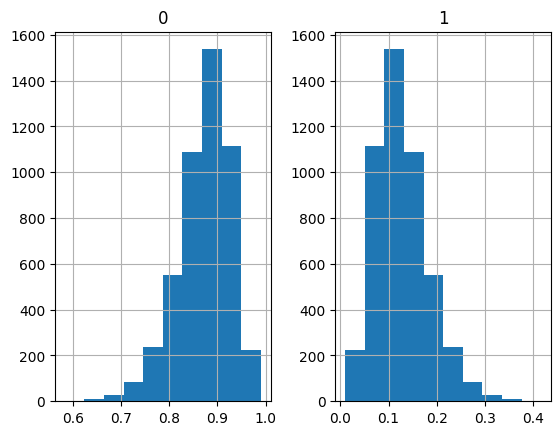

In [67]:
y_test = predictor.predict_proba(test_data, model=model_name)
perf = predictor.evaluate_predictions(
    y_true=test_data["y"], y_pred=y_test, auxiliary_metrics=True
)
y_test.hist(), perf

AUC Score: 0.6348290988502598


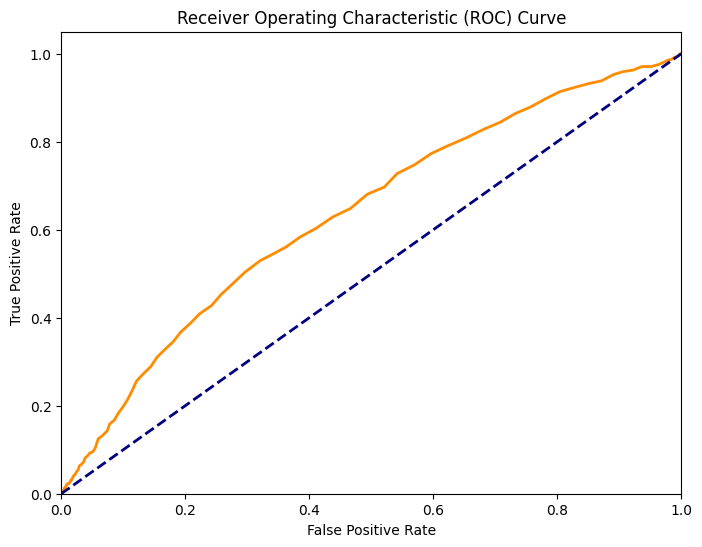

In [68]:
auc_score = roc_auc_score(test_data['y'], y_test[1])
print(f"AUC Score: {auc_score}")

fpr, tpr, thresholds = roc_curve(test_data['y'], y_test[1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.show()

In [69]:
pred = predictor.predict_proba(test, model=model_name)[1]
pred

0       0.163333
1       0.093333
2       0.120000
3       0.070000
4       0.140000
          ...   
6562    0.143333
6563    0.080000
6564    0.083333
6565    0.150000
6566    0.140000
Name: 1, Length: 6567, dtype: float64

## Feature

In [70]:
predictor.feature_importance(test_data)

KeyboardInterrupt: 

# Submit

(<Axes: >, <Axes: >)

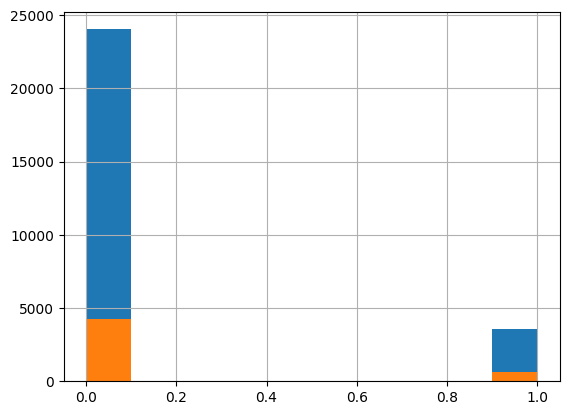

In [71]:
train_data['y'].hist(), test_data['y'].hist()

<Axes: >

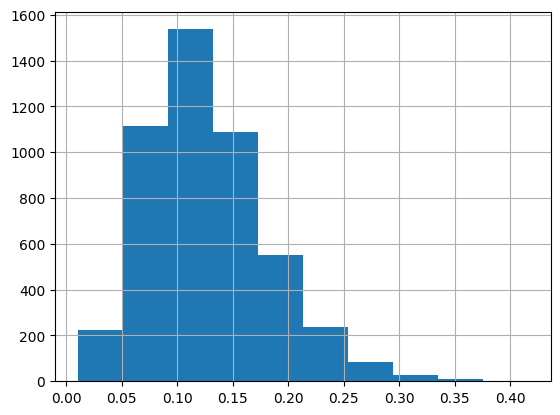

In [72]:
y_test[1].hist()

<Axes: >

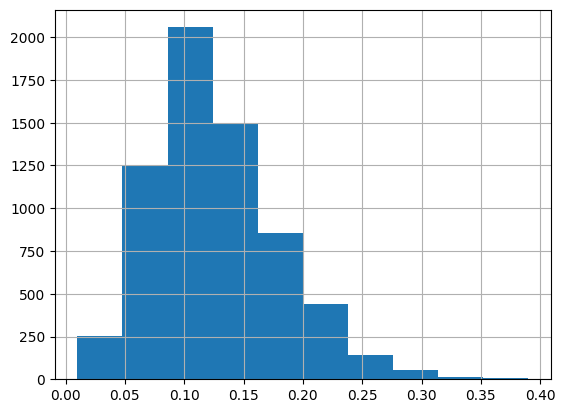

In [73]:
pred.hist()

In [74]:
sub = pd.read_csv(data_root + 'submission_template_for_public.csv')
# sub = sub[['no']]
sub

,ID,default_12month
0,2.024120e+11,0
1,2.024120e+11,0
2,2.024120e+11,0
3,2.024120e+11,0
4,2.024120e+11,0
...,...,...
6562,2.024120e+11,0
6563,2.024120e+11,0
6564,2.024120e+11,0
6565,2.024120e+11,0


In [75]:
sub['default_12month'] = pred
sub

,ID,default_12month
0,2.024120e+11,0.163333
1,2.024120e+11,0.093333
2,2.024120e+11,0.120000
3,2.024120e+11,0.070000
4,2.024120e+11,0.140000
...,...,...
6562,2.024120e+11,0.143333
6563,2.024120e+11,0.080000
6564,2.024120e+11,0.083333
6565,2.024120e+11,0.150000


In [76]:
sub.to_csv(f'99_v2_{model_name}.csv', index=False)
# sub.to_csv(".csv", index=False)

In [ ]:
eval_auc(train_data)

In [ ]:
import os

In [ ]:
model_names = predictor.model_names()

save_path = 'submission/'
os.makedirs(save_path, exist_ok=True)

for model_name in model_names:
    try:
        pred = predictor.predict(test, model=model_name)
    except:
        print(f"Model {model_name} does not support predict method")
        continue
    # Compute AUC-ROC
    
    sub['default_12month'] = pred
    sub.to_csv(f'{save_path}99_{model_name}.csv', index=False)